# Прогноз литологии по данным геофизических исследований скважин


Автор: Егоров Дмитрий (Газпромнефть - НТЦ)


Контакты:

Почта - zelilockerz@gmail.com

github - https://github.com/zelizpriest
slack ODS - @zel1

Telegram - @DmitryEgorovGeol

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/3.0/"><img alt="Лицензия Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/3.0/88x31.png" /></a><br />Это произведение доступно по <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/3.0/">лицензии Creative Commons С указанием авторства-Некоммерческая-Без производных 3.0 Непортированная</a>.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/3.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/3.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/3.0/">Creative Commons Attribution-NonCommercial-NoDerivs 3.0 Unported License</a>.

## 1.1 Описание кейса
В нефтяной индустрии одной из главных задач является интерпретация данных геофизических исследований скважин (каротажных данных). После того, как скважина была пробурена, в нее опускаются приборы, которые меряют различные физических характеристики пород. После этого полученные данные интерпретируются специалистами петрофизиками, последние выделяют различные литологии, а именно интервалы глин и песчанника.
Выделение литологии является достаточно рутинной, но очень трудоемкой задачей. Переинтерпретация данных происходит достаточно часто, как в связи с измененией модели выделения песчаника, так и связи с появлением новых скважин. Поскольку количество скважин может исчисляться тысячами, хотелось бы создать инструмент, который смог бы помогать специалисту в этом задании.

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve, learning_curve
import time
import math
%matplotlib inline

**Права на данный принадлежат комании ООО "Газпромнефть - НТЦ"**

Скачиваем данные [отсюда](https://github.com/zelizpriest/well_log_interpretation/tree/master/data).

In [2]:
# Загружаем данные тренировочной части
train_data = pd.read_csv('../../data/Well_logs_interp_test_train.csv')

## 1.2 Описание данных

На основе седиментологического описания одного из обнажений геологических обнажений, расположенного в Томской области (Шестаковский полигон), была построена 3D геологическая модель.

Модель представляет из себя трехмерный грид ячеек. Каждая ячейка определена как песчанник, либо как глина, также в каждой из них имеется запись геофизических исследований.

Столбец **Well** показывает то, к какой скважине принадлежат измерения. Название скважины отражает ее координаты на месторождении.

Каждая скважина представлена 4 каротажными кривыми:
- **DEPT** (глубина записи дискрета, в общем случае, она нас не интересует и не может выступать как признак, так как зависит от различных тектонических подвижек, произошедших после отложения осадка, а не от процесса формирования геологических тел)
- **SP** (каротаж естественной поляризации, последняя возникает при фильтрации флюида через породу, уменьшение значений говори о наличии проницаемого интервала, единица измерения - милливольты)
- **GR** (гамма каротаж, измеряет естественную радиоактивность пород, различные минералы имеют разное содержание радиоактивных материалов, как правило, чем выше - тем больше глинистая составляющая и меньше песчанистая, измеряется в единица API)
- **DT** (акустический каротаж, измеряет скорость прохождения акустической волны сквозь породу, как правило, с пониженные значения могут говорить как о высокой пористости, характерной для песчанника, так и о количестве глины, измеряется в микросекундах/метр)
- **Density** (плотностной каротаж, основан на комптоновском рассеянии, отражает плотность породы, измеряется в граммах/см^3)

В качестве кривой интерпретации столбец **Litho**, который при значении **1** говорит о песчанник, а при значении **0** о глинах.

Одна из скважин в таком виде, в каком с ней работают специалисты, представлена ниже.
<img src="../../img/log_interpretation.png">

## 2. Первичный анализ данных

В этом блоке будет проведен первичный анализ данных, будут оценены признаки и их распределния, а также влияние на целевой параметр.

In [3]:
# Посмотрим, какие типы данных представлены в загруженном файле и есть ли в нем пропуски
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151788 entries, 0 to 151787
Data columns (total 7 columns):
DEPT     151788 non-null float64
SP       151788 non-null float64
GR       151788 non-null float64
DT       151788 non-null float64
Dens     151788 non-null float64
Litho    151788 non-null float64
Well     151788 non-null object
dtypes: float64(6), object(1)
memory usage: 8.1+ MB


Можно сделать вывод, что пропуски отсутствуют, а все описанные кривые геофизических исследований представлены в полном объеме.

In [4]:
# Посмотрим описание данных, оценим основные статистические характеристики
# Также посмотрим 5 и 95 перцентили, для оценки выбросов
print(train_data.quantile(0.05))
print(train_data.quantile(0.95))
train_data.describe()

DEPT     2497.400000
SP       -122.897548
GR         60.151279
DT        292.742395
Dens        2.303052
Litho       0.000000
Name: 0.05, dtype: float64
DEPT     2527.400000
SP        -40.782377
GR        115.384490
DT        327.813771
Dens        2.370171
Litho       1.000000
Name: 0.95, dtype: float64


,DEPT,SP,GR,DT,Dens,Litho
count,151788.000000,151788.000000,151788.000000,151788.000000,151788.000000,151788.000000
mean,2514.115326,-77.602441,90.740329,307.239603,2.342066,0.326837
std,9.225971,27.610223,19.813850,11.700474,0.022185,0.469059
min,2485.600000,-125.710487,57.799000,283.431244,2.295403,0.000000
25%,2507.900000,-102.601227,71.479460,297.900398,2.323819,0.000000
50%,2514.900000,-73.188686,93.196541,303.321304,2.349032,0.000000
75%,2521.000000,-52.391197,110.928368,316.836189,2.359683,1.000000
max,2543.700000,-38.943268,116.989639,330.196503,2.390196,1.000000


Можно увидеть, что значения находятся в совершенно разных масштабах, что естественно, так как измеряются разные физические характеристики. По колонке **Litho**, можно отметить, что песчанник занимает лишь 33 процента от данных, что делает проблему несколько несбалансированной. 
Поскольку 5-ый и 95-ый перцентили имеют значения близкие к минимальным и максимальным, то стоит проверить данные на выбросы.

In [5]:
# Дополнительно оценим количество выбросов, выходишь за два стандартных отклонения для каждой из кривой
for column in ['SP', 'GR', 'DT', 'Dens']:
    mean = train_data[column].mean()
    std = train_data[column].std()
    print('Number of outlies for well log %s is %d'%(column,
                                                     (train_data.loc[train_data[column] >=
                                                                     mean + 2*std,column].shape[0] + 
                                                      train_data.loc[train_data[column] <=
                                                                     mean - 2*std,column].shape[0])))

Number of outlies for well log SP is 0
Number of outlies for well log GR is 0
Number of outlies for well log DT is 6
Number of outlies for well log Dens is 180


Можно увидеть, что кривая плотностно каротажа содержит значительное количество выбросов в терминах стандартных отклонений, которые надо будет обработать.

In [6]:
# Посмотрим статистику по данным только внутри песчанника

train_data[train_data.Litho == 1].describe()

,DEPT,SP,GR,DT,Dens,Litho
count,49610.000000,49610.000000,49610.000000,49610.000000,49610.000000,49610.0
mean,2516.906164,-106.892918,69.180502,321.079429,2.316126,1.0
std,8.104946,16.117922,10.178552,6.783960,0.013066,0.0
min,2486.500000,-125.710487,57.799000,296.502716,2.295403,1.0
25%,2512.300000,-120.695625,60.758951,316.024910,2.305022,1.0
50%,2517.600000,-111.513931,65.072681,323.076538,2.312493,1.0
75%,2522.500000,-96.082655,75.860752,327.113075,2.325808,1.0
max,2543.700000,-51.742474,106.203720,330.196503,2.364369,1.0


Можно отметить, что интервалах песчанника кривые **SP** и **GR** имеют пониженное значение, что вполне естественно, так как песчанник содержит мало глинистых радиоактивных минералов, а способность интервала к фильтрации создает разницу потенциалов. Несколько пониженные значения плотностей говорят о наличии порового пространства и являются признаком песчанника. Повышенные значения времени интервального пробега волны говорят о пониженной скорости, что также подразумевает последний вывод о наличии порового пространстве, так как скорость распространения волн в низкоплотных материалах ниже.

In [7]:
# Посмотрим статистику по данным только внутри глин

train_data[train_data.Litho == 0].describe()

,DEPT,SP,GR,DT,Dens,Litho
count,102178.000000,102178.000000,102178.000000,102178.000000,102178.000000,102178.0
mean,2512.760304,-63.381174,101.208169,300.520018,2.354661,0.0
std,9.430507,19.685669,14.058346,6.547820,0.012763,0.0
min,2485.600000,-125.150154,61.666225,283.431244,2.304919,0.0
25%,2506.400000,-75.580473,92.060478,297.142609,2.348363,0.0
50%,2513.000000,-58.874048,104.892914,298.612457,2.357442,0.0
75%,2520.100000,-46.874451,114.104574,303.610832,2.362033,0.0
max,2542.500000,-38.943268,116.989639,326.635010,2.390196,0.0


В интервалах глин мы видим обратную ситуацию, кривые **SP** и **GR** имеют повышенные значения, также несколько повысились значения плотностного каротажа, а также понизились значения акустической кривой.

In [8]:
# Оценим корреляцию параметров
corr_mat = train_data.corr()
corr_mat

,DEPT,SP,GR,DT,Dens,Litho
DEPT,1.000000,-0.318592,-0.295897,0.259763,-0.254371,0.210780
SP,-0.318592,1.000000,0.968334,-0.847600,0.836283,-0.739203
GR,-0.295897,0.968334,1.000000,-0.828405,0.814750,-0.758200
DT,0.259763,-0.847600,-0.828405,1.000000,-0.981716,0.824204
Dens,-0.254371,0.836283,0.814750,-0.981716,1.000000,-0.814764
Litho,0.210780,-0.739203,-0.758200,0.824204,-0.814764,1.000000


Как и предполагалось ранее, какая-то корреляция между глубиной и физическими характеристиками отсутствует, в связи с тем, что рассматривается не очень большой интервал пласта (на глубинах измеряемых километрами некая связь должна прослеживаться в связи с уплотнением пород и большими давлениями). Также можно отметить высокую корреляцию каротажей, что естественно, так как многие физические характеристики тесно связаны друг с другом.

## 3. Визуальный анализ данных

В этом блоке будет проведен визуальный анализ данных с целью получить какую-то дополнительную информацию о распределении параметров, имеющихся зависимостях в них и оценить выбросы.

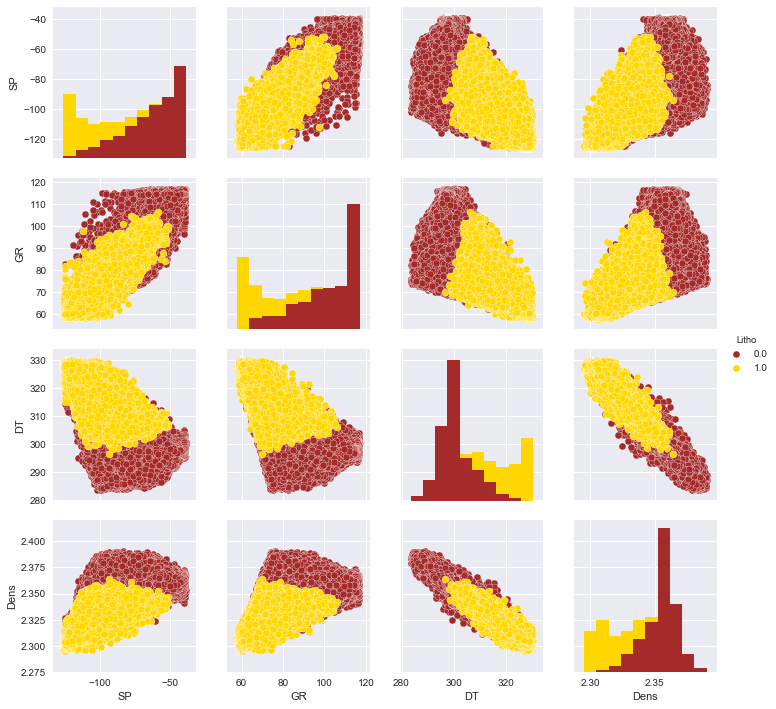

In [9]:
# Проведем визуальную оценку имеющийся информации через pairplot'ы

sns.pairplot(train_data, vars = ['SP', 'GR', 'DT', 'Dens'], hue = 'Litho', palette = ['brown', 'gold'])

По результатам визуальной оценки можно отметить, что классы достаточно хорошо линейно разделимы в поле двух значений, хотя имеется значительная доля перекрытия, которая не позволяет легко линейными моделями получить высокое значение точности.
Также важно отметить наличие вылетов, которые не было опознаны при первичном анализе и которые в дальнейшем стоит обработать. Например, отлетающие точки на кросс-плотах кривых **GR** и **SP**.

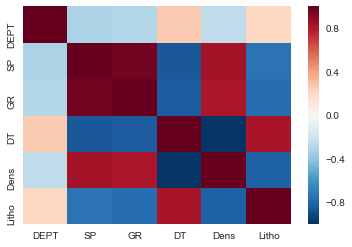

In [10]:
# Построим heatmap по ранее созданной корреляционной матрицы для более наглядной оценки связей между кривыми
sns.heatmap(corr_mat)

На основе карты температур все также подтверждается предположение об отсутствии каких-то связей между показаниями приборов и глубиной, поэтому пока данный параметр можно не использовать, так как он может внести дополнительный шум.

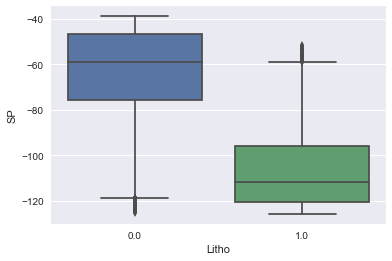

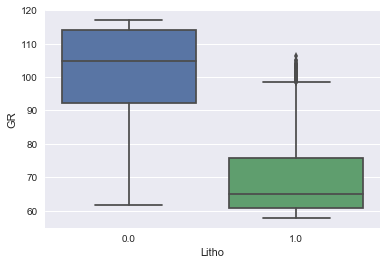

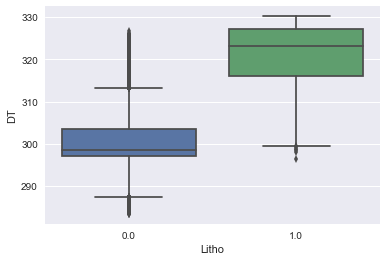

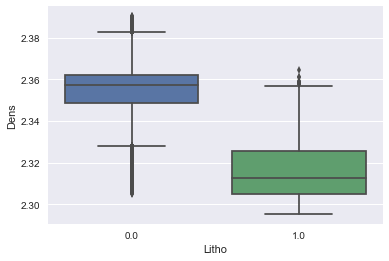

In [11]:
# Построим бокс-плоты по четырем геофизическим кривым, чтобы оценить распределение значений внутри классов
for column in ['SP', 'GR', 'DT', 'Dens']:
    plt.figure()
    sns.boxplot(data = train_data, x = 'Litho', y = column)
    plt.show()

И снова можно увидеть, что большая часть данных достаточно легко линейно разделима, но такое разделение не даст необходимого уровня точности из-за имеющихся перекрытий.

Также стоит отметить наличие значительного количества выбросов акустического и плотностного каротажа в глинистых интервалах.

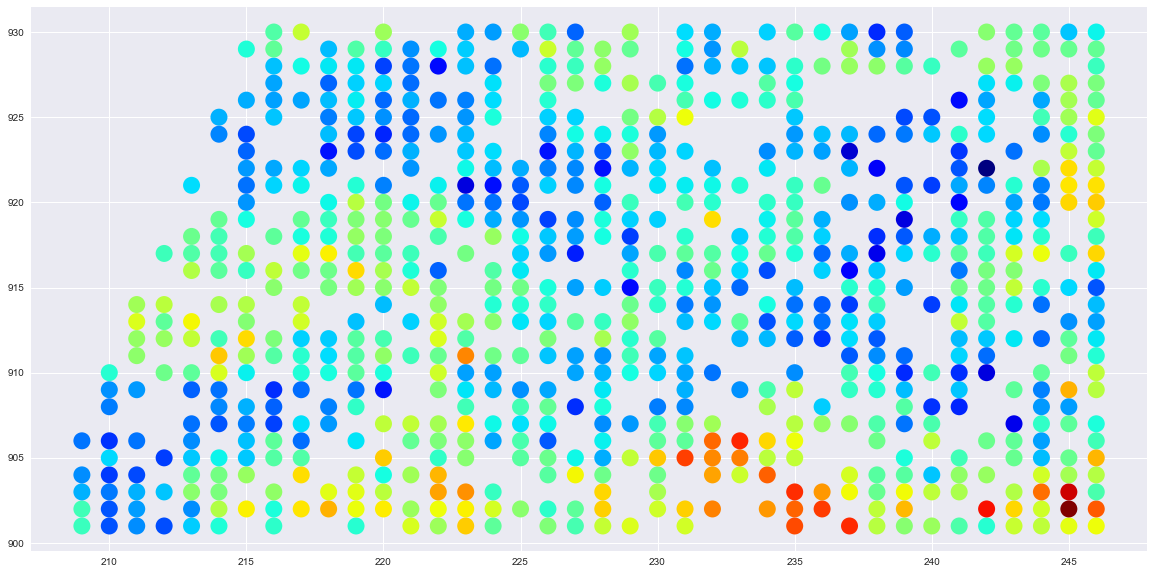

In [12]:
# Попробуем оценить можно ли извлечь информацию из координат скважин
well_check = pd.DataFrame()
for well in train_data.Well.unique():
    well_x, well_y = map(int, well.split('-'))
    well_pd = pd.DataFrame({'X':well_x,
                           'Y':well_y,
                           'Sand_ratio':train_data[train_data.Well == well]['Litho'].value_counts(1)[1]},
                           index = [0])
    well_check = well_check.append(well_pd)
plt.figure(figsize=(20, 10))
plt.scatter(x = well_check['X'], y = well_check['Y'], c = well_check['Sand_ratio'], cmap = 'jet', lw = 10)

Можно отметить, что значения повышенной песчанистости (отношения толщины интервалов песчанника к общей толщине интервала) имеет некую зависимость от координат. Повышенные значения расположены на юге и западе месторождения.

## 4. Инсайты, найденные зависимости

По результатам анализа можно отметить, что кривые достаточно хорошо коррелируются. Также есть связь между классами и значениями кривых. Так, для целевого класса песчанник (1) характерны пониженные значения кривых SP и GR, так как интервалы при фильтрации флюида создают разницу потенциалов, а наличие малого количества глины не дает повышаться кривой гамма-каротажа. Пониженные значения плотностей предполагают наличие порового пространства, характерного для песчанников. Повышенные значения интервального времени пробега волны связаны с понижением скорости, которая в свою очередь зависит от плотности породы. Последние утверждения также позволяют предположить, что в будущем стоит попробовать использование дополнительного признака - акустического импеданса, который является произведение плотности породы на скорость в ней.

По результатам анализа, как первичного, так и визуального, было установлено, что классы достаточно хорошо линейно разделими в поле двух каротажных кривых. При этом разделение далеко не идеальное и требует доработки через построение новых признаков.

Было выявлено значительное количество вылетов, особенно на кривой плотностного каротажа. В дальнейшем такие точки необходимо обработать (замена значений за двумя стандартными отклонениями на значение двух стандартных отклонений).

Важным выводом было заключение о возможности извлечения дополнительной информации из координат скважины, которые до этого не рассматривались как признак который можно использовать. В дальнейшем стоит опробовать его в качестве дополнительного признака.

## 5. Выбор метрики

Поскольку мы имеем дело с задачей классификации, выбор метрики может быть сделан из списка следующего списка самых распротранненых метрик для подобной задачи: accuracy, precision, recall, F1, ROC-AUC

Метрика **Accuracy** не подходит, так как имеется дисбаланс классов, и, например, если алгоритм предскажет все значения как глина, то сразу получим 70% точности, что не верно.

Метрики **precision** и **recall** не стоит применять, так как в данном случае сложно поставить задачу в подобном ключе, чтобы мы могли выбрать какая метрика важнее в данной проблеме.

Наилучшим вариантом в случае несбалансированности классов является **F1** и **AUC** метрики, так как они индиффирентны к количеству и представленности каждого класса. 

В первую очередь внимание будет сосредоточено именно на **AUC**, так как она идеально подходит для задачи бинарной классификации в которой есть проблема несбалансированности классов.

## 6. Выбор модели

Основные требования к модели - возможность работать с разномасштабными данными, устойчивость к выбросам и несбалансированности в классах.

Поскольку одни и те же кривые каротажных исследований имеют одинаковый масштаб во всех скважинах, то нет необходимости использовать модели, который могли бы разделять классы при значениях, выбивающихся за эти масштабы. Таким образом можно сразу исключить линейные модели. Для ряда моделей требуется, чтобы все данные были в одинаковом масштабе, чего нет в данной задаче. Данные можно нормализовать, но это может привести к другим проблемам. Поэтому пока что стоит отказаться от подобных моделей, например, от К ближайших соседей.

Для данной задачи идеально подойдут модели, работающие на построении ансамблей деревьев. Ансамбли устойчивы к выбросам и им неважен масштаб данных. Огромным плюсом является их возможность "раздвинуть" классы, которые, как было показано ранее, достаточно сильно перехлестываются. Важное преимущество - более устойчивая работа с несбалансированной выборкой, благодаря бэггингу и бустингу.

В данной работе был выбран классификатор **GradientBoostinClassifier** библиотеки **scikit-learn** как один из лучших представителей в своем классе.

## 7. Предобработка данных

В данном блоке будет проведена предобработка данных, будут обработаны выбросы, а также проведено разбиение на тренировочную и тестовую части. Поскольку во всех скважинах данные записаны в одинаковом масштабе, индивидуальном для каждого типа кривой, необходимость в нормализации или стандартизации отсутствует, так как будет использоваться модель построенная на ансамбле деревьев, индиффирентная к масштабу данных.

In [13]:
# Обработаем вылеты, приравняв все значения находящиеся за 5-ым или 95-ым перцентилем в соответствующие значения
train_no_outliers = train_data.copy()
for column in ['SP', 'GR', 'DT', 'Dens']:
    quant_95 = train_no_outliers[column].quantile(0.95)
    quant_5 = train_no_outliers[column].quantile(0.05)
    train_no_outliers.loc[train_no_outliers[column] > quant_95, column] = quant_95
    train_no_outliers.loc[train_no_outliers[column] < quant_5, column] = quant_5

Как было отмечено ранее, координата скважины, извлеченная из ее названия, также может нести в себе информацию. Стоит обработать название и превратить его в соответствующие признак **X** и **Y**. Это будет одним из шагов на пути генерации дополнительных данных (feature engineering), который также будет дополнен позднее.

In [14]:
# извлечем данные из названий скважин и получим координаты
train_no_outliers['X'] = ([int(i[:3]) for i in train_no_outliers.Well.values])
train_no_outliers['Y'] = [int(i[-3:]) for i in train_no_outliers.Well.values]

Разобьем данные на тренировочную и hold-out, которые будут использоваться для обучения модел и настройки гиперпараметров. В заключительной части работы будет использоваться дополнительная выборка, которая была отложена ранее и находится в другом файле.

Говоря о разбиении на тренировочную и hold-out выборки, следует подчеркнуть, что правильнее будет разбивать весь набор данных именно по отдельным скважинам, нежели просто случайно разделить все значения сета коробочным train_test_split'ом.

Значения для разбиения будут стандартными 0.7 для тренировочной части и 0.3 для hold-out.

In [15]:
# Разобьем данные на тренировочную и hold-out выборку по скважинам
train_test = 0.7
rd.seed(17)
train_wells = rd.sample(train_data.Well.unique().tolist(), round(train_test*len(train_data.Well.unique())))
train_set = train_no_outliers.loc[train_no_outliers.Well.isin(train_wells)]
test_set = train_no_outliers.loc[~train_no_outliers.Well.isin(train_wells)]

In [16]:
# Разобьем полученные выборки на матрицу признаков и вектор ответов
Feature_train = train_set.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_train = train_set['Litho']

Feature_test = test_set.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_test = test_set['Litho']

## 8. Построение модели, кросс-валидация и настройка гиперпараметров

В данной части будет проведена работа с построением выбранной модели и настройкой ее гиперпараметров.

Поскольку на этапе визуального анализа данных было отмечено, что классы вполне хорошо линеймо разделими, возьмем простую модель логистической регрессии в качестве baseline-решения, точность которого будет необходимо превзойти в рамках разработки более сложного подхода в решению задачи.

In [17]:
# Построем baseline-модель логистической регрессии от метрик которой будем отталкиваться
baseline_clf = RidgeClassifier()
baseline_clf.fit(Feature_train, Target_train)
baseline_prediction = baseline_clf.predict(Feature_test)
roc_auc_base = roc_auc_score(Target_test, baseline_prediction)
f1_base = f1_score(Target_test, baseline_prediction)
print('ROC-AUC метрика baseline модели равна %.4f'%roc_auc_base)
print('F1 метрика baseline модели равна %.4f'%f1_base)

ROC-AUC метрика baseline модели равна 0.8961
F1 метрика baseline модели равна 0.8606


Как можно увидеть, результат уже достаточно неплохой, но это было вполне очевидно, что линейное разделение должно хорошо себя вести. Дело в том, что выделяя пропластки мы подразумеваем их последующую перфорацию (взрыв на выделенной глубине с целью получить приток из пласта) и подсчет находящихся в них запасах, поэтому даже такой высокой оценки как 0.85 может быть недостаточно для использования инструмента.

In [18]:
# Создадим обьект для кросс-валидацонной выборки
stratified_cv = StratifiedKFold(n_splits=3, random_state=17)

Для кросс-валидации был использован стандартный пакет библиотеки sklearn - StratifiedKFold.

Стратифицированная версия была выбрана в связи с несбалансированностью классов, данная библиотека позволяет разделять выборки равномерно.

Параметр **random_state** был зафиксирован для возможности повторить результат.

Поскольку дата-сет достаточно большой, вычислительные мощности не позволяют проводить стратификацию на очень большом количестве складок. Чтобы оценить разлет значений на кросс-валидации и при этом не перегрузить компьютер, количество складок (параметр **n_splits**) было выбрано равным трем.

In [19]:
# Создадим саму модель с зафиксированным сидом
clf = GradientBoostingClassifier(random_state=17,
                                 learning_rate = 0.01,
                                 subsample = 0.5,
                                max_depth = 8,
                                max_features = 'auto')

# Определим словарь параметров, по которому будет происходить отбор признаков
grid_params = {'n_estimators':list(range(100, 1001, 100))}

# Создадим классификатор для поиска лучших гиперпараметров
# Поскольку диапазов гиперпараметров очень широкий, кросс-валидации проходит по 5 складкам
# Используем RandomizedSearchCV вместо стандартного GridSearchCV, который проходит по всем вариациям параметров

grid_clf = GridSearchCV(clf, 
                              param_grid=grid_params,
                              cv = stratified_cv,
                              scoring = 'roc_auc',
                              n_jobs = -1)

start_time = time.time()

# Обучим модель
grid_clf.fit(Feature_train, Target_train)

end_time = time.time()

print('Модель обучилась за %d секунд.'%(end_time-start_time))


Модель обучилась за 998 секунд.


Был создан объект классификатора, который будет использоваться в последующем тюнинге с постоянным параметров **random_state** для возможности повторения результата.

Во время тюнинга модели производился подбор и настройка следующих гиперпараметров:

- **learning_rate** - отвечает за скорость, с которой будет происходить обучение классификатора, уменьшает вклад каждого дерева в прогноз
- **n_estimators** - количество деревьев в ансамбле, по которому принимается окончатльное решение, увеличение, обычно, ведет к улучшению качества модели
- **max_depth** - максимальная глубина до которой строится дерево, тем самым ограничивая количество листьев в нем
- **subsample** - количество данных, используемых при построении дерева, если значение меньше нуля, то в результате обучения получится некий аналог стохастического градиентного спуска
- **max_features** - количество признаков, по которым будут строиться деревья

Поскольку дата-сет достаточно большой, а различных параметров для настройки также достаточно много, полный перебор параметров непосредственно в работе может занять значительное время. В связи с этим предварительно был произведен достаточно долгий **RandomizedSearchCV**, позволивший определить наилучшие значения для части из параметров (которые уже инициализированы в модели при ее создании).

В представленном ноутбуке же производится поиск лишь по количеству деревьев (**n_estimators**) с помощью **GridSearchCV**, этот параметр, в большинстве случаев, вносит наибольший вклад в качество прогноза и поэтому интересен с точки зрения анализа его влияния в процессе валидации. Метрикой качества был выставлен **roc_auc**, который ранее был определен как наиболее подходящая для данной задачи. Также для ускорения расчета был выставлен параметр **n_jobs = -1**, позволяющий алгоритму задействовать все ядра процессора.

In [20]:
# Определим наилучшие параметры модели

print('Выбранное количество деревьев:\n%s'%grid_clf.best_params_['n_estimators'])

# Определим точность модели на кросс-валидации
print('На кросс валидации лучший результаты по ROC-AUC составил %.4f'%grid_clf.best_score_)

# Определим точность модели на тестовой выборке для ее сравнения с baseline-решением
prediction_clf = grid_clf.predict(Feature_test)
roc_auc_clf = roc_auc_score(Target_test, prediction_clf)
f1_clf = f1_score(Target_test, prediction_clf)
print('ROC-AUC метрика полученной модели градиентного бустинга на тестовой части равна %.4f'%roc_auc_clf)
print('F1 метрика полученной модели градиентного бустинга на тестовой части равна %.4f'%f1_clf)
print('Разница между настроенной моделью градиентного бустинга и baseline по ROC-AUC метрике равна %.4f'%(
    roc_auc_clf-roc_auc_base))
print('Разница между настроенной моделью градиентного бустинга и baseline по F1 метрике равна %.4f'%(
    f1_clf-f1_base))

Выбранное количество деревьев:
300
На кросс валидации лучший результаты по ROC-AUC составил 0.9842
ROC-AUC метрика полученной модели градиентного бустинга на тестовой части равна 0.9161
F1 метрика полученной модели градиентного бустинга на тестовой части равна 0.8901
Разница между настроенной моделью градиентного бустинга и baseline по ROC-AUC метрике равна 0.0200
Разница между настроенной моделью градиентного бустинга и baseline по F1 метрике равна 0.0294


Как мы видим, использование модели градиентного бустинга с настроенными параметрами дало прирост к точности прогнозирования.

## 9. Создание новых признаков (feature engineering)

В данной части будет проведена работа по созданию новых признаков на основе физического смысла проводимых исследований, а также с помощью различных математических трансформаций уже имеющихся данных.

Некоторые дополнительные признаки уже были созданы ранее - координаты расположения скважин X и Y, полученные из названий скважин.

Дополнительно будут созданы следующие параметры:

### Физические и геологические признаки

- **Скорость продольной волны** - скорость прохождения волны в породе, чем меньше параметр - тем более пористая порода
- **Акустический импеданс** - произведение скорости прохождения волны в породе на ее плотность, обычно пониженные значения акустического импеданса говорят о наличии песчанника. Данная кривая будет строиться на основе кривой акустического и плотностного каротажей.
- **Пористость по плотностному каротажу** - отношение пор в породе к общему объему породы расчитанное по данным плотностного каротажа. Считается по формуле (Density-зерен-породы-Dens)/(Density-зерен-породы - Density-флюида)
- **Пористость по акустическому каротажу** - отношение пор в породе к общему объему породы расчитанное по данным акустического каротажа. Считается по формуле (DT-DT-зерен-породы)/(DT-флюида-DT-зерен-породы)

### Математические признаки

- **Степенные кривые** - имеющиеся кривые будут возведены в степень в целью дополнительно разделить классы в разных пространствах
- **Производная кривой** - с ее помощью можно более четко подчеркивать границы пластов, будет считаться как разница двух ближайших значений деленная на величину дискрета - 0.1 м.
- **Логарифм кривой** - поскольку некоторые кривые распределены ненормально, можно попробовать взять их логарифм и работать в этом пространстве.

In [21]:
# Повторим предыдущие шаги из обработки данных чтобы пересоздать дата-сет
train_featured = train_data.copy()
for column in ['SP', 'GR', 'DT', 'Dens']:
    quant_95 = train_featured[column].quantile(0.95)
    quant_5 = train_featured[column].quantile(0.05)
    train_featured.loc[train_featured[column] > quant_95, column] = quant_95
    train_featured.loc[train_featured[column] < quant_5, column] = quant_5

# извлечем данные из названий скважин и получим координаты
train_featured['X'] = ([int(i[:3]) for i in train_featured.Well.values])
train_featured['Y'] = [int(i[-3:]) for i in train_featured.Well.values]

# Добавим физические и геологические признаки
# Добавим признак скорости продольной волны в породе
train_featured['P_velocity'] = 1/train_featured['DT']

# Добавим признак акустического импеданса
train_featured['Acoustic_imp'] = train_featured['DT']*train_featured['Dens']

# Добавим признак пористости по плотностному каротажу, плотность породы возьмем постоянной 2.65, флюида - 1 г/см^3
train_featured['Por_Dens'] = (2.65 - train_featured['Dens'])/(2.65-1)

# Добавим признак пористости по плотностному каротажу, интервальное время пробега в породе - 180
# интервальное время пробега во флюиду - 616
train_featured['Por_DT'] = (train_featured['DT'] - 180)/(616-180)


# Добавим математические признаки
# Добавим степенные кривые и логарифм
for column in ['SP', 'GR', 'DT', 'Dens']:
    train_featured['%s^2'%column] = train_featured[column]*train_featured[column]
    train_featured['%s^3'%column] = train_featured[column]*train_featured[column]*train_featured[column]
    if column != 'SP':
        train_featured['Log_%s'%column] = np.log(train_featured[column])
    
# Добавим производную, стоит отметить, что ее следует считать индивидуально для каждой скважины
for column in ['SP', 'GR', 'DT', 'Dens']:
    train_featured['%s_gradient'%column] = 0
    for well in train_featured.Well.unique():
        train_featured.loc[train_featured.Well == well,
                           '%s_gradient'%column] = np.gradient(train_featured.loc[train_featured.Well == well,
                                                                                  column], 0.1)

# Разобьем данные на тренировочную и hold-out выборку по скважинам
train_test = 0.7
rd.seed(17)
train_wells = rd.sample(train_data.Well.unique().tolist(), round(train_test*len(train_data.Well.unique())))
train_set_featured = train_featured.loc[train_featured.Well.isin(train_wells)]
test_set_featured = train_featured.loc[~train_featured.Well.isin(train_wells)]

# Разобьем полученные выборки на матрицу признаков и вектор ответов
Feature_train_feat = train_set_featured.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_train_feat = train_set_featured['Litho']

Feature_test_feat = test_set_featured.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_test_feat = test_set_featured['Litho']

Проведем новый подбор гиперпараметров в связи с тем, что выбранные ранее значения могут измениться в связи с расширением списка доступных для алгоритма признаков. По результатам будет проведена оценка значимости новых признаков. Как и в прошлый раз, в следствие необходимости значительного времени для поиска наилучших параметров, часть из них была выбрана заранее, а в самой работе представлена только часть, отвечающая за выбор оптимального количества решающих деревьев.

In [22]:
# Создадим саму модель с зафиксированным сидом
clf_feat = GradientBoostingClassifier(random_state=17,
                                     subsample = 0.7,
                                     max_features = 12,
                                     max_depth = 8,
                                     learning_rate = 0.1)

# Определим словарь параметров, по которому будет происходить отбор признаков
grid_params = {'n_estimators':list(range(100, 2101, 200))}

# Создадим классификатор для поиска лучших гиперпараметров
# Поскольку диапазов гиперпараметров очень широкий, кросс-валидации проходит по 5 складкам
# Используем RandomizedSearchCV вместо стандартного GridSearchCV, который проходит по всем вариациям параметров

grid_clf_feat = GridSearchCV(clf_feat,
                              param_grid=grid_params,
                              cv = stratified_cv,
                              scoring = 'roc_auc',
                              n_jobs = -1)

start_time = time.time()

# Обучим модель
grid_clf_feat.fit(Feature_train_feat, Target_train_feat)

end_time = time.time()

print('Модель обучилась за %d секунд.'%(end_time-start_time))


Модель обучилась за 4645 секунд.


In [23]:
# Определим наилучшие параметры модели

print('Выбранное количество деревьев для новой модели:\n%s'%grid_clf_feat.best_params_['n_estimators'])

# Определим точность модели на кросс-валидации
print('На кросс валидации лучший результаты модели составил %.4f'%grid_clf_feat.best_score_)

# Определим точность модели на тестовой выборке для ее сравнения с baseline-решением
prediction_clf_feat = grid_clf_feat.predict(Feature_test_feat)
roc_auc_clf_feat = roc_auc_score(Target_test, prediction_clf_feat)
f1_clf_feat = f1_score(Target_test, prediction_clf_feat)
print('ROC-AUC метрика полученной модели градиентного бустинга равна на тестовой части %.4f'%roc_auc_clf_feat)
print('F1 метрика полученной модели с расширенными признаками равна %.4f'%f1_clf_feat)
print('Разница между настроенной моделью с расширенными признаками и baseline по ROC-AUC метрике равна %.4f'%(
    roc_auc_clf_feat-roc_auc_base))
print('Разница между настроенной моделью с расширенными признаками и baseline по F1 метрике равна %.4f'%(
    f1_clf_feat-f1_base))
print('Разница между настроенной моделью с расширенными признаками и без них по ROC-AUC метрике равна %.4f'%(
    roc_auc_clf_feat-roc_auc_clf))
print('Разница между настроенной моделью с расширенными признаками и без них по F1 метрике равна %.4f'%(
    f1_clf_feat-f1_clf))


Выбранное количество деревьев для новой модели:
1700
На кросс валидации лучший результаты модели составил 0.9922
ROC-AUC метрика полученной модели градиентного бустинга равна на тестовой части 0.9518
F1 метрика полученной модели с расширенными признаками равна 0.9363
Разница между настроенной моделью с расширенными признаками и baseline по ROC-AUC метрике равна 0.0557
Разница между настроенной моделью с расширенными признаками и baseline по F1 метрике равна 0.0756
Разница между настроенной моделью с расширенными признаками и без них по ROC-AUC метрике равна 0.0357
Разница между настроенной моделью с расширенными признаками и без них по F1 метрике равна 0.0462


Посмотрим, какие признаки являются для модели определяющими.

In [24]:
pd.DataFrame({'Feature':Feature_train_feat.columns,
             'Importance':grid_clf_feat.best_estimator_.feature_importances_}
            ).sort_values('Importance', ascending = False).iloc[:10,]

,Feature,Importance
22,GR_gradient,0.073781
23,DT_gradient,0.068275
24,Dens_gradient,0.059888
7,Acoustic_imp,0.055077
21,SP_gradient,0.055046
10,SP^2,0.043644
12,GR^2,0.043179
13,GR^3,0.042350
14,Log_GR,0.042243
1,GR,0.040897


Видно, что топе наиболее важных признаков для модели находятся как раз те, которые были получены по результатам feature engineering'a.

Подводя итог, можно сделать вывод, что построение новых признаков позволило значительно повысить качество предсказаний модели, увеличив значения точности на несколько процентов, что еще раз говорит о важности применения экспертного знания для извлечения дополнительной информации из уже имеющейся. 

## 10. Построение кривых валидации и обучения


В данной части будет продемонстрировано графическое отображение процесса обучения модели, а именно зависимость качества предсказания от размера обучающей выборки и количества решающих деревьев. При построении кривых будут использовать результаты полученные по итогу поиска наилучшего количества решающих деревьев на модели с расширенным количеством признаков.

In [45]:
# Возьмем стандартную функцию для отрисовки learning_curve с сайта sklearn

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure().set_size_inches(18, 10)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


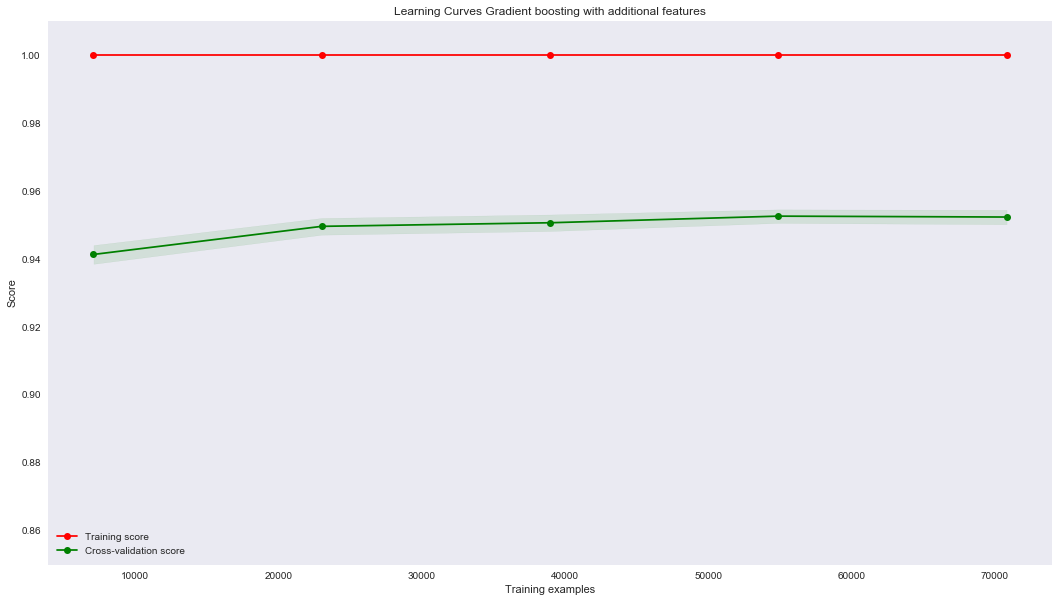

Время потраченное на отрисовку составляет 1175.260407447815 секунд


In [46]:
# Отрисуем learning_curve, чтобы оценить зависимость качества обучения от количества тренировочных данных
start_time = time.time()
title = "Learning Curves Gradient boosting with additional features"
plot_learning_curve(grid_clf_feat.best_estimator_, title,
                    Feature_train_feat,
                    Target_train_feat,
                    (0.85, 1.01),
                    cv=stratified_cv,
                    n_jobs=-1)

plt.show()
print('Время потраченное на отрисовку составляет %s секунд'%(time.time()-start_time))

По результатам полученных кривых можно судить о том, что от количества входной информации качество меняется незначительно. Скорее всего это связано с достаточно простой геологией, которая незначительно меняется в пределах месторождения, а также с стандартным видом всех кривых ГИС, которые ведут себя идиентично во всех скважинах.

Теперь построим валидационную кривую для количества деревьев, используемых классификатором, чтобы определить правильно ли было выбрано их количество и оценить эффект от настройки этого параметра.

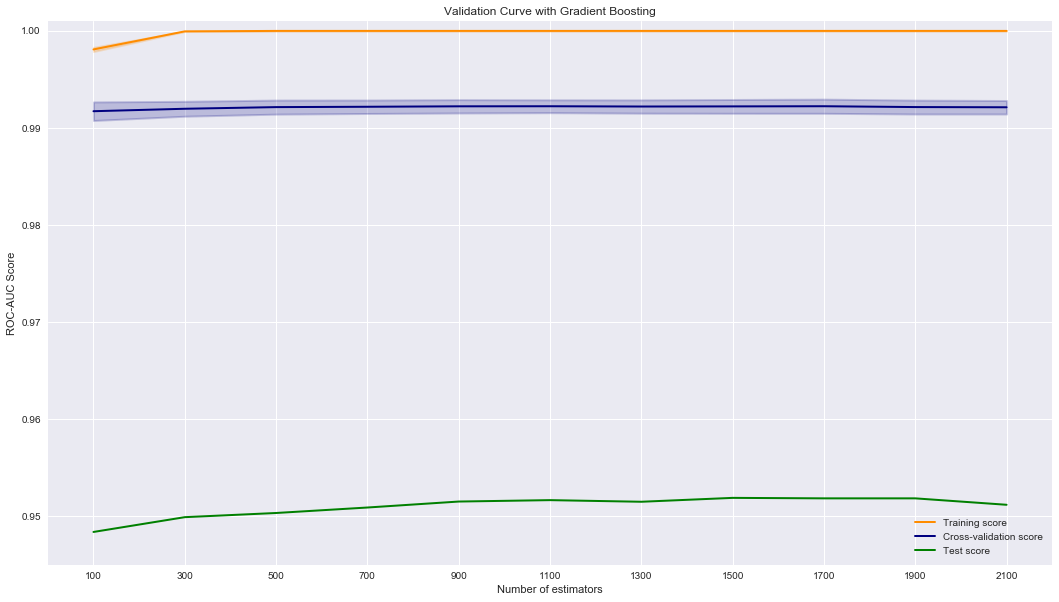

In [42]:
param_range = list(range(100, 2101, 200))
train_scores_mean = grid_clf_feat.cv_results_['mean_train_score']
train_scores_std = grid_clf_feat.cv_results_['std_train_score']
valid_scores_mean = grid_clf_feat.cv_results_['mean_test_score']
valid_scores_std = grid_clf_feat.cv_results_['std_test_score']
test_scores = []
for i in range(100, 2101, 200):
    clf_check = GradientBoostingClassifier(random_state=17,
                                         subsample = 0.7,
                                         max_features = 12,
                                         max_depth = 8,
                                         learning_rate = 0.1,
                                         n_estimators = i)
    clf_check.fit(Feature_train_feat, Target_train_feat)
    prediction_check = clf_check.predict(Feature_test_feat)
    roc_auc_check = roc_auc_score(Target_test, prediction_check)
    test_scores.append(roc_auc_check)
plt.figure().set_size_inches(18, 10)
plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Number of estimators")
plt.ylabel("ROC-AUC Score")
plt.ylim(0.945, 1.001)
plt.xticks(param_range)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.plot(param_range, test_scores, label="Test score", color="green", lw=lw)
plt.legend(loc="best")
plt.show()

Можно увидеть, что несмотря на то, что количество деревьев, выбранное алгоритмом, составляет 1700, реально можно было остановиться на количестве 900, так как существует простое правило о том, что при увеличении емкости (сложности) модели, увеличивается вероятность того, что она будет переобучена.

## 11. Прогноз для тестовой или отложенной выборки 

В данном блоке будет произведен прогноз и оценена его точность на выборке, которая изначально была отложена. Не следует путать эту выборку с тестовой частью, которая была "отрезана" от обучающей выборки, на которой производилась предыдущая работа и тестировалась baseline-модель.

In [30]:
# Загрузим отложенные данные
hold_data = pd.read_csv('../../data/Well_logs_interp_hold.csv')

In [31]:
# Проверем, что в данных нет отсутствующих значений
hold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61416 entries, 0 to 61415
Data columns (total 7 columns):
DEPT     61416 non-null float64
SP       61416 non-null float64
GR       61416 non-null float64
DT       61416 non-null float64
Dens     61416 non-null float64
Litho    61416 non-null float64
Well     61416 non-null object
dtypes: float64(6), object(1)
memory usage: 3.3+ MB


In [32]:
# Проверем, что данные находятся в тех же масштабах и диапазонах
hold_data.describe()

,DEPT,SP,GR,DT,Dens,Litho
count,61416.000000,61416.000000,61416.000000,61416.000000,61416.000000,61416.000000
mean,2513.126697,-77.586401,90.728613,307.229977,2.342106,0.324199
std,9.716555,27.520166,19.780978,11.603030,0.022080,0.468079
min,2485.100000,-125.689812,58.159077,283.392731,2.295538,0.000000
25%,2506.500000,-102.434147,71.528109,297.933640,2.323992,0.000000
50%,2514.100000,-73.125549,93.087879,303.357498,2.349041,0.000000
75%,2520.500000,-52.470391,110.997198,316.758484,2.359718,1.000000
max,2541.200000,-39.076138,116.912079,329.899292,2.390461,1.000000


In [33]:
# Повторим предыдущие шаги из обработки данных чтобы сделать такое же пространство признаков как и ранее
hold_featured = hold_data.copy()

# Оставим квантили из предыдущего датасета, чтобы одинакого ограничить масштабы кривых
for column in ['SP', 'GR', 'DT', 'Dens']:
    quant_95 = train_featured[column].quantile(0.95)
    quant_5 = train_featured[column].quantile(0.05)
    hold_featured.loc[hold_featured[column] > quant_95, column] = quant_95
    hold_featured.loc[hold_featured[column] < quant_5, column] = quant_5

# извлечем данные из названий скважин и получим координаты
hold_featured['X'] = ([int(i[:3]) for i in hold_featured.Well.values])
hold_featured['Y'] = [int(i[-3:]) for i in hold_featured.Well.values]

# Добавим физические и геологические признаки
# Добавим признак скорости продольной волны в породе
hold_featured['P_velocity'] = 1/hold_featured['DT']

# Добавим признак акустического импеданса
hold_featured['Acoustic_imp'] = hold_featured['DT']*hold_featured['Dens']

# Добавим признак пористости по плотностному каротажу, плотность породы возьмем постоянной 2.65, флюида - 1 г/см^3
hold_featured['Por_Dens'] = (2.65 - hold_featured['Dens'])/(2.65-1)

# Добавим признак пористости по плотностному каротажу, интервальное время пробега в породе - 180
# интервальное время пробега во флюиду - 616
hold_featured['Por_DT'] = (hold_featured['DT'] - 180)/(616-180)


# Добавим математические признаки
# Добавим степенные кривые и логарифм
for column in ['SP', 'GR', 'DT', 'Dens']:
    hold_featured['%s^2'%column] = hold_featured[column]*hold_featured[column]
    hold_featured['%s^3'%column] = hold_featured[column]*hold_featured[column]*hold_featured[column]
    if column != 'SP':
        hold_featured['Log_%s'%column] = np.log(hold_featured[column])
    
# Добавим производную, стоит отметить, что ее следует считать индивидуально для каждой скважины
for column in ['SP', 'GR', 'DT', 'Dens']:
    hold_featured['%s_gradient'%column] = 0
    for well in hold_featured.Well.unique():
        hold_featured.loc[hold_featured.Well == well,
                           '%s_gradient'%column] = np.gradient(hold_featured.loc[hold_featured.Well == well,
                                                                                  column], 0.1)

# Разобьем данные на тренировочную и hold-out выборку по скважинам
train_test = 0.7
rd.seed(17)


# Разобьем полученные выборки на матрицу признаков и вектор ответов
Feature_hold = hold_featured.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_hold = hold_featured['Litho']

In [34]:
# Предскажим данные тестовой части и посчитаем метрики
predict_hold = grid_clf_feat.predict(Feature_hold)
f1_hold = f1_score(Target_hold, predict_hold)
roc_auc_hold = roc_auc_score(Target_hold, predict_hold)

print('ROC-AUC метрика по отложенной части равна %.4f'%roc_auc_hold)
print('F1 метрика по отложенной части равна %.4f'%f1_hold)
print('Разница между предсказаниями на отложенной и тестовой частью по ROC-AUC метрике равна %.4f'%(
    roc_auc_hold - roc_auc_clf_feat))
print('Разница между предсказаниями на отложенной и тестовой частью по F1 метрике равна %.4f'%(
    f1_hold - f1_clf_feat))

ROC-AUC метрика по отложенной части равна 0.9513
F1 метрика по отложенной части равна 0.9348
Разница между предсказаниями на отложенной и тестовой частью по ROC-AUC метрике равна -0.0005
Разница между предсказаниями на отложенной и тестовой частью по F1 метрике равна -0.0015


На отложенной части модель показала результаты на том же уровне, которые были получены по результатм опробования на тестовом сете. Это позволяет сделать заключение о хорошей обобщающей способности модели и отсутствии переобучения на имеющемся тренировочном наборе.

## 12. Выводы

Основной целью данной работы являлась разработка подхода по автоматической интерпретации данных геофизических исследований скважин на основе алгоритмов машинного обучения.


В ходе работы решались следующие задачи:
- **Анализ и предобработка имеющихся данных**
- **Извлечение дополнительной информации из имеющихся данных**
- **Выбор метрики качества**
- **Обучение и настройка модели**
- **Проверка модели на отложенной выборке**

Все поставленные задачи были выполнены, в качестве итога была разработан алгоритм выделения песчанника. Полученная в результате работы модель позволяет с высокой долей уверенности проводить автоматическую интерпретацию каротажных кривых. Ее ценность заключается в том, что она может быть использована в качестве помощника для геолога или петрофизика при выполнении рутинной работы по выделению литологии, что значительно сокращает требуемое на работу время.
#### Дальнейшие исследования
В дальнейшем можно попробовать использовать более сложные модели для проверки их качества. Одним из направлений работ может быть построение дополнительных кривых по уже имеющимся, поскольку, как было показано в исследовании, дополнительные признаки дают значительный прирост в качестве прогноза. Например, таким признаком может быть геостатистический разрез, который используется в процессе геологического моделирования.